Librerias

In [1]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import cv2
from fractions import Fraction
from pyrobex.robex import robex
from sklearn.cluster import KMeans

Primera Entrega - Proyecto MRI

In [2]:
data_dir_analyze = 'MRIsamples/analyze/'
data_dir_nifti = 'MRIsamples/analyze_to_nii/'
data_dir_robex = 'MRIsamples/robex/'
data_ext = ['.img', '.hdr', '.nii']
filenames = ['4_8', '8_4', '100_23', '205_3', '1_24', '202_3']

In [3]:
# for filename in filenames:
#     try:
#         #Se carga la imagen MRI simple en formato ANALYZE
#         path = data_dir_analyze + filename
#         img = nb.load(path + data_ext[0])
#         hdr = nb.load(path + data_ext[1])

#         #Se muestra la información del encabezado
#         print(f"Archivo: '{filename}'")
#         print(hdr.header)
#         print('*********************************************************************')
        
#         #Se convierte el formato de ANALYZE a NIFTI
#         nii = nb.nifti1.Nifti1Image(img.get_fdata(), 
#                                     hdr.affine, 
#                                     hdr.header)

#         #Se guarda la imagen MRI simple en formato NIFTI
#         path = data_dir_nifti + filename + data_ext[2]
#         nb.save(nii, path)
#     except FileNotFoundError:
#         print(f"No se pudo cargar el archivo: '{filename}'")
#         print('*********************************************************************')
#     except AttributeError:
#         print(f"El archivo: '{filename}', se encuentra vacio")
#         print('*********************************************************************')

Segunda Entrega - Proyecto MRI

(130, 132)


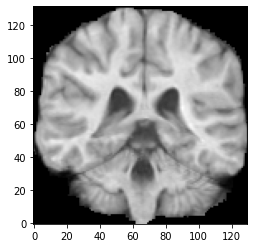

In [4]:
path = data_dir_robex + 'filename' + data_ext[2]
#path = data_dir_nifti + 'filename' + data_ext[2]

# Se cargan las imagenes en formato NIFTI
# img_4_8 = nb.load(path.replace('filename', filenames[0]))
# img_8_4 = nb.load(path.replace('filename', filenames[1]))
# img_8_4 = nb.load(path.replace('filename', filenames[1] + '_stripped'))
# img_100_23 = nb.load(path.replace('filename', filenames[2]))
# img_205_3 = nb.load(path.replace('filename', filenames[3]))
# img_1_24 = nb.load(path.replace('filename', filenames[4] + '_stripped'))
img_202_3 = nb.load(path.replace('filename', filenames[5] + '_stripped'))

#se extrae un corte de la imagen sagital
#img1 = img_4_8.get_fdata()
#img1 = img1[150,:,:][:,:,0]
#img1 = img1[0:58,92:210]

#se extrae un corte de la imagen coronal 
# img2 = img_8_4.get_fdata()
# img2 = img2[:,20,:]
# img2 = img2[71:194,77:187]

#se extrae un corte de la imagen axial 
#img3 = img_100_23.get_fdata()
#img3 = img3[:, : ,157][:,:,0]
#img3 = img3[58:196, 0:55]

#se extrae un corte de la imagen axial 
# img4 = img_1_24.get_fdata()
# img4 = img4[:, 16, :]
# img4 = img4[72:188, 74:182]

img5 = img_202_3.get_fdata()
img5 = img5[:, 26, :]
img5 = img5[64:194, 93:225]

print(img5.shape)
plt.imshow(img5.T, origin='lower', cmap='gray')
plt.show()

Difusión Anisotrópica - Explicita

In [5]:
# def convolution(img, kernel):
#     convolvedImg = np.zeros((img.shape[0], img.shape[1]))
#     v = int(kernel.shape[0] / 2)
    
#     for j in range(convolvedImg.shape[0]):
#         for i in range(convolvedImg.shape[1]):
#             mat = mask(img, j, i, v)
#             res = np.sum(np.multiply(mat, kernel))
#             convolvedImg[j, i] = res
    
#     return convolvedImg

In [6]:
# def mask(img, j, i, v):
#     n = 2 * v + 1
#     mat = np.full((n, n), -1)
    
#     jmin = (j - v, 0)[(j - v) < 0]
#     jmax = (jmin + n, jmin + (n - 1))[(j + v) == img.shape[0] or (j - v) < 0]
    
#     imin = (i - v, 0)[(i - v) < 0]
#     imax = (imin + n, imin + (n - 1))[(i + v) == img.shape[1] or (i - v) < 0]
    
#     f = (0, 1)[(j - v) < 0]
#     c1 = (0, 1)[(i - v) < 0]
    
#     for j in range(jmin, jmax):
#         c = c1
        
#         for i in range(imin, imax):
#             mat[f, c] = img[j, i]
#             c += 1
            
#         f += 1
            
#     return mat

In [7]:
# def anisotropic_diffusion(img, c):
#     scale = Fraction(c) * Fraction(1, 4)
    
#     k = np.zeros((3, 3))
#     #k[1, 1] = 4 / c
#     k[0, 1] = 1
#     k[1, 0] = 1
#     k[1, 2] = 1
#     k[2, 1] = 1

#     img_f = convolution(img.copy(), k)
#     img_f = np.multiply(img_f, float(scale))
    
#     return img_f

Difusión Anisotrópica - Implícita

In [8]:
def create_A_x_b(img, c):
    m = img.shape[0] * img.shape[1]
    scale = Fraction(c) * Fraction(1, 4)
    A = np.identity(m)
    x = np.array([img.flatten()]).T
    b = np.zeros((m , 1))
    i = 1
    
    for f in range(m - 1):
        c1 = f + 1
        c2 = f + img.shape[1]
        
        if i < img.shape[1]:
            A[f, c1] = -scale
            A[c1, f] = -scale
            
            if c2 < m:
                A[f, c2] = -scale
                A[c2, f] = -scale
                
            i += 1
        else:
            A[f, c2] = -scale
            A[c2, f] = -scale
            i = 1
    
    return A,x,b

In [9]:
def general_method(A, x, b, Q, maxit):
    I = np.identity(A.shape[0])
    Q_inv = np.linalg.inv(Q)
    new_A = I - np.dot(Q_inv, A)
    new_b = np.dot(Q_inv, b)
    x_k_anterior = x
    i = 0

    while i < maxit:
        x = np.dot(new_A, x_k_anterior) + new_b        
        x_k_anterior = x
        i = i + 1

    return x_k_anterior

In [10]:
def jacobi_method(A, x, b, maxit):
    Q = np.zeros((A.shape[0], A.shape[1]))
    for i in range(Q.shape[0]):
        Q[i,i] = A[i,i]    
    return general_method(A, x, b, Q, maxit)

In [11]:
def gaussseidel_method(A, x, b, maxit):
    Q_tri_inf = np.tril(A, 0)
    return general_method(A, x, b, Q_tri_inf, maxit)

In [12]:
def x_to_img(img, x):
    i = j = 0
    
    img1 = np.zeros((img.shape[0], img.shape[1]))
    
    for f in range(x.shape[0]):
        img1[j, i] = x[f, 0]
        i = i + 1
        
        if i == img.shape[1]:
            i = 0
            j = j + 1
    
    return img1

Tercera Entrega - Proyecto MRI

In [13]:
def newtonRaphson(img, lineal_method, maxiter_nr, maxiter_lm, c):
    A, x0, b = create_A_x_b(img, c)
    x_k_anterior = x0 
    x0_l_m = np.zeros(x0.shape)
    i = 0
    data = None
    while i < maxiter_nr:
        x0_l_m = x_k_anterior + x0_l_m
        data = lineal_method(A, x0_l_m, b, maxiter_lm)
        x = x_k_anterior - data
        x_k_anterior = x
        i += 1 
    return x_k_anterior

Resultados

In [14]:
# def difussionAnisotropica(img, maxiter, c):
#     x = anisotropic_diffusion(img, c)
#     for i in range(1, maxiter):
#         x = anisotropic_diffusion(x, c)
#     return x

In [15]:
# image_ex = difussionAnisotropica(img2, 3, 0.9)

In [16]:
# Netwon Raphson evaluado en metodo de jacobi
image_nr_jc = newtonRaphson(img5, jacobi_method, 15, 100, 0.75)

In [17]:
# Netwon Raphson evaluado en metodo de gauss seidel
# image_nr_gs = newtonRaphson(img2, gaussseidel_method, 5, 100 , 0.6)

Segmentación

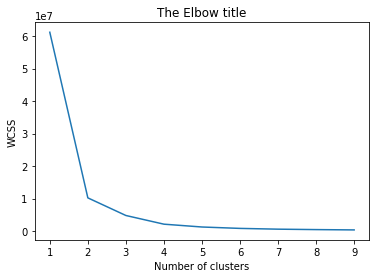

In [30]:
wcss=[]
all_pixels = img5.reshape((-1,1))

for i in range(1,10):
    km = KMeans(n_clusters=i)
    km.fit(all_pixels)
    wcss.append(km.inertia_)
    
number_cluster = range(1,10)
plt.plot(number_cluster, wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [31]:
def segmentation_kmeans(img, n_clusters_):
    original_shape = img.shape
    all_pixels = img.reshape((-1,1))
    
    segs = {
        'probabilityimages': [],
        'segmentation': np.zeros(all_pixels.shape)
    }
    
    for i in range(n_clusters_):
        segs['probabilityimages'].append(np.zeros(all_pixels.shape))
    
    km = KMeans(n_clusters=n_clusters_).fit(all_pixels)
    centers = np.array(km.cluster_centers_, dtype='uint8')
    
    for ix in range(all_pixels.shape[0]):
        segs['segmentation'][ix] = centers[km.labels_[ix]]
        
        for i in range(n_clusters_):
            if i == km.labels_[ix]:
                segs['probabilityimages'][i][ix] = centers[km.labels_[ix]]
            
    segs['segmentation'] = segs['segmentation'].reshape((original_shape))
    
    for i in range(n_clusters_):
        segs['probabilityimages'][i] = segs['probabilityimages'][i].reshape((original_shape))
        
    return segs

In [32]:
img_segs = segmentation_kmeans(img5, 4)

In [33]:
# plt.imshow(img5.T, origin='lower', cmap='gray')
# plt.show()

In [34]:
img_nr_jc = x_to_img(img5, image_nr_jc)

# plt.imshow(img_nr_jc.T, origin='lower', cmap='gray')
# plt.show()

In [23]:
# plt.imshow(img_segs['segmentation'].T, origin='lower', cmap='gray')
# plt.show()

In [24]:
# plt.imshow(img_segs['probabilityimages'][0].T, origin='lower', cmap='gray')
# plt.show()

In [25]:
# plt.imshow(img_segs['probabilityimages'][1].T, origin='lower', cmap='gray')
# plt.show()

In [26]:
# plt.imshow(img_segs['probabilityimages'][2].T, origin='lower', cmap='gray')
# plt.show()

In [27]:
# plt.imshow(img_segs['probabilityimages'][3].T, origin='lower', cmap='gray')
# plt.show()

Text(0.5, 1.0, 'probabilityimages2')

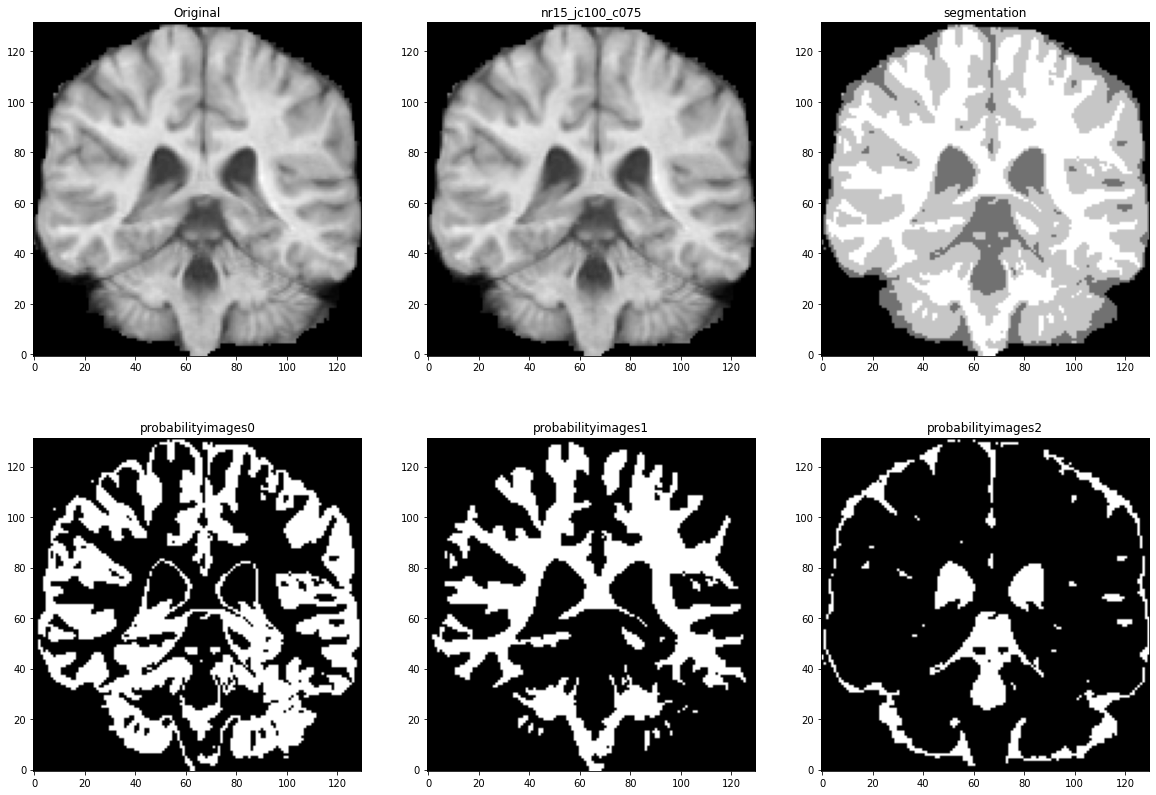

In [35]:
figure, axis = plt.subplots(ncols = 3, nrows = 2, figsize=(20, 14))
axis[0, 0].imshow(img5.T, origin='lower', cmap='gray')
axis[0, 0].set_title("Original")
axis[0, 1].imshow(img_nr_jc.T, origin='lower', cmap='gray')
axis[0, 1].set_title("nr15_jc100_c075")
axis[0, 2].imshow(img_segs['segmentation'].T, origin='lower', cmap='gray')
axis[0, 2].set_title("segmentation")
axis[1, 0].imshow(img_segs['probabilityimages'][0].T, origin='lower', cmap='gray')
axis[1, 0].set_title("probabilityimages0")
axis[1, 1].imshow(img_segs['probabilityimages'][2].T, origin='lower', cmap='gray')
axis[1, 1].set_title("probabilityimages1")
axis[1, 2].imshow(img_segs['probabilityimages'][3].T, origin='lower', cmap='gray')
axis[1, 2].set_title("probabilityimages2")